In [1]:
# Import our dependencies.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
# Import the kerastuner library
import keras_tuner as kt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import psycopg2

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# Pass in password once.  ### Add your passwork here <pw> ###
postgresInfo = 'postgresql://postgres:<pw>@localhost/Weather_Crime'

In [3]:
## Create table and fill with contents of dataframe  - crime data
conn_string = postgresInfo

db = create_engine(conn_string)
conn = db.connect()

conn = psycopg2.connect(conn_string
                        )
conn.autocommit = True
cursor = conn.cursor()

crime_df = pd.read_sql_query('''SELECT * FROM all_crime;''', db)

crime_df

,event_unique_id,crime,occ_year,occ_month,occ_day,occ_dow,occ_hour,premises_type,hood_140,neighbourhood_140,long_wgs84,lat_wgs84,date
0,GO-20155154,assault,2015,January,1,Thursday,23,House,115,Mount Dennis (115),-79.504668,43.693238,2015-01-01
1,GO-20151233,assault,2015,January,1,Thursday,3,Commercial,77,Waterfront Communities-The Island (77),-79.392855,43.647315,2015-01-01
2,GO-2015862,assault,2015,January,1,Thursday,2,Commercial,77,Waterfront Communities-The Island (77),-79.387700,43.649776,2015-01-01
3,GO-2015182,assault,2015,January,1,Thursday,0,Commercial,1,West Humber-Clairville (1),-79.595562,43.686751,2015-01-01
4,GO-2015276,assault,2015,January,1,Thursday,0,Outside,77,Waterfront Communities-The Island (77),-79.400096,43.645835,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166507,GO-20181887731,homicide,2018,October,12,Friday,0,None,75,Church-Yonge Corridor (75),-79.376699,43.656958,2018-10-12
166508,GO-20181923388,homicide,2018,October,18,Thursday,0,None,120,Clairlea-Birchmount (120),-79.286292,43.699070,2018-10-18
166509,GO-20181939006,homicide,2018,October,20,Saturday,0,None,124,Kennedy Park (124),-79.264551,43.732765,2018-10-20
166510,GO-20182113063,homicide,2018,November,16,Friday,0,None,73,Moss Park (73),-79.369005,43.654614,2018-11-16


In [4]:
## Create table and fill with contents of dataframe  - weather data
conn_string = postgresInfo

db = create_engine(conn_string)
conn = db.connect()

conn = psycopg2.connect(conn_string
                        )
conn.autocommit = True
cursor = conn.cursor()

weather_df = pd.read_sql_query('''SELECT * FROM weather;''', db)

weather_df

,date,max_temperature,min_temperature,max_relative_humidity,avg_relative_humidity,avg_pressure_sea,max_wind_speed,precipitation,rain,snow,snow_on_ground,daylight,avg_cloud_cover_8
0,2018-12-31,5.0,-2.5,94,79.5,100.78,21,13.6,13.6,0.0,0.0,8.98,4.5
1,2018-12-30,0.7,-6.6,88,78.0,102.03,24,1.2,0.0,1.6,2.0,8.97,5.0
2,2018-12-29,2.7,-7.0,80,68.0,101.86,34,0.0,0.0,0.0,0.0,8.95,4.5
3,2018-12-28,12.4,2.7,95,84.5,100.89,30,1.8,1.8,0.0,0.0,8.93,4.5
4,2018-12-27,2.8,-7.4,87,74.0,102.52,30,5.4,5.4,0.0,0.0,8.93,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2015-01-05,-5.8,-14.4,83,69.5,102.38,45,0.8,0.0,0.8,1.0,9.05,3.5
1457,2015-01-04,4.3,-5.9,98,82.5,100.69,43,6.8,6.4,0.4,0.0,9.02,6.0
1458,2015-01-03,1.5,-5.8,97,82.5,101.96,29,10.8,8.0,2.4,0.0,9.00,5.0
1459,2015-01-02,-1.0,-6.1,83,66.0,102.30,36,0.6,0.0,0.4,0.0,9.00,6.0


In [5]:
#Closing the connection
conn.close()

In [6]:
# Create new dataframe by counting occurences of certain crimes and grouping by date and day of the week (occ_dow)
# From MM script
daily_crime = crime_df.groupby(by=['date', "occ_dow"])["crime"].value_counts().unstack(fill_value=0)
daily_crime

,crime,assault,auto_theft,bicycle_theft,break_and_enter,homicide,robbery,shooting,theft_from_motor_vehicle,theft_over
date,occ_dow,,,,,,,,,
2015-01-01,Thursday,158,7,5,21,0,8,0,34,5
2015-01-02,Friday,34,9,4,18,0,6,0,34,2
2015-01-03,Saturday,37,10,0,4,0,8,0,21,3
2015-01-04,Sunday,44,5,1,11,0,5,0,33,1
2015-01-05,Monday,39,6,1,24,0,5,1,31,2
...,...,...,...,...,...,...,...,...,...,...
2018-12-27,Thursday,38,7,2,21,0,7,0,30,1
2018-12-28,Friday,35,13,2,21,0,12,0,31,1
2018-12-29,Saturday,37,10,3,26,0,7,0,21,4


In [7]:
# Reset index to flatten the dataframe
daily_crime.reset_index(inplace=True)
daily_crime

crime,date,occ_dow,assault,auto_theft,bicycle_theft,break_and_enter,homicide,robbery,shooting,theft_from_motor_vehicle,theft_over
0,2015-01-01,Thursday,158,7,5,21,0,8,0,34,5
1,2015-01-02,Friday,34,9,4,18,0,6,0,34,2
2,2015-01-03,Saturday,37,10,0,4,0,8,0,21,3
3,2015-01-04,Sunday,44,5,1,11,0,5,0,33,1
4,2015-01-05,Monday,39,6,1,24,0,5,1,31,2
...,...,...,...,...,...,...,...,...,...,...,...
1456,2018-12-27,Thursday,38,7,2,21,0,7,0,30,1
1457,2018-12-28,Friday,35,13,2,21,0,12,0,31,1
1458,2018-12-29,Saturday,37,10,3,26,0,7,0,21,4
1459,2018-12-30,Sunday,43,8,3,22,0,7,0,22,3


In [8]:
# Merge weather and crime dataframes
joined_df = pd.merge(weather_df, daily_crime, on="date", how="left")

joined_df

,date,max_temperature,min_temperature,max_relative_humidity,avg_relative_humidity,avg_pressure_sea,max_wind_speed,precipitation,rain,snow,...,occ_dow,assault,auto_theft,bicycle_theft,break_and_enter,homicide,robbery,shooting,theft_from_motor_vehicle,theft_over
0,2018-12-31,5.0,-2.5,94,79.5,100.78,21,13.6,13.6,0.0,...,Monday,38,14,2,20,0,11,0,23,4
1,2018-12-30,0.7,-6.6,88,78.0,102.03,24,1.2,0.0,1.6,...,Sunday,43,8,3,22,0,7,0,22,3
2,2018-12-29,2.7,-7.0,80,68.0,101.86,34,0.0,0.0,0.0,...,Saturday,37,10,3,26,0,7,0,21,4
3,2018-12-28,12.4,2.7,95,84.5,100.89,30,1.8,1.8,0.0,...,Friday,35,13,2,21,0,12,0,31,1
4,2018-12-27,2.8,-7.4,87,74.0,102.52,30,5.4,5.4,0.0,...,Thursday,38,7,2,21,0,7,0,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2015-01-05,-5.8,-14.4,83,69.5,102.38,45,0.8,0.0,0.8,...,Monday,39,6,1,24,0,5,1,31,2
1457,2015-01-04,4.3,-5.9,98,82.5,100.69,43,6.8,6.4,0.4,...,Sunday,44,5,1,11,0,5,0,33,1
1458,2015-01-03,1.5,-5.8,97,82.5,101.96,29,10.8,8.0,2.4,...,Saturday,37,10,0,4,0,8,0,21,3
1459,2015-01-02,-1.0,-6.1,83,66.0,102.30,36,0.6,0.0,0.4,...,Friday,34,9,4,18,0,6,0,34,2


In [9]:
joined_df.columns

Index(['date', 'max_temperature', 'min_temperature', 'max_relative_humidity',
       'avg_relative_humidity', 'avg_pressure_sea', 'max_wind_speed',
       'precipitation', 'rain', 'snow', 'snow_on_ground', 'daylight',
       'avg_cloud_cover_8', 'occ_dow', 'assault', 'auto_theft',
       'bicycle_theft', 'break_and_enter', 'homicide', 'robbery', 'shooting',
       'theft_from_motor_vehicle', 'theft_over'],
      dtype='object')

#### Assault

In [10]:
# Define crime type variables
df = 'assault_df'
crime_type = 'assault'

In [11]:
# Drop the non-beneficial columns, from crime data
#joined_df.drop(columns=['occ_dow','auto_theftocc_year', 'occ_month', 'occ_day', 'occ_dow', 'occ_hour', 'premises_type', 'hood_140', 'neighbourhood_140', 'long_wgs84', 'lat_wgs84' ], inplace=True)
df = joined_df.copy()
df.drop(columns=['occ_dow','auto_theft', 'bicycle_theft', 'break_and_enter', 'homicide', 'robbery', 'shooting', 'theft_from_motor_vehicle', 'theft_over'], inplace=True)

# # Drop the non-beneficial columns, from weather 
df.drop(columns=['date','max_temperature', 'min_temperature', 'max_relative_humidity', 'avg_relative_humidity', 'avg_pressure_sea', 'max_wind_speed', 'rain', 'snow', 'snow_on_ground', 'daylight', 'avg_cloud_cover_8'], inplace=True)

df

,precipitation,assault
0,13.6,38
1,1.2,43
2,0.0,37
3,1.8,35
4,5.4,38
...,...,...
1456,0.8,39
1457,6.8,44
1458,10.8,37
1459,0.6,34


In [12]:
# Determine the number of unique values in each column.
unique =df.nunique()
unique

precipitation    112
assault           75
dtype: int64

In [13]:
# Corrolation Matrix
corr_matrix = df.corr()

print(corr_matrix)

               precipitation   assault
precipitation       1.000000 -0.018992
assault            -0.018992  1.000000


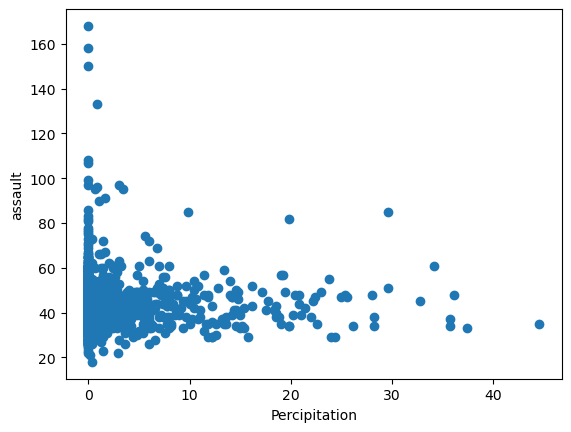

In [14]:
plt.scatter(df.precipitation, df[crime_type])
plt.xlabel('Percipitation')
plt.ylabel(crime_type)
plt.show()

In [15]:
# The data in the df column must be reshaped into an array with shape (num_samples, num_features)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
X = df.precipitation.values.reshape(-1, 1)

X

array([[13.6],
       [ 1.2],
       [ 0. ],
       ...,
       [10.8],
       [ 0.6],
       [ 0. ]])

In [16]:
# The shape of X is 30 samples, with a single feature (column)
X.shape

(1461, 1)

In [17]:
y=df[crime_type]
y

0        38
1        43
2        37
3        35
4        38
       ... 
1456     39
1457     44
1458     37
1459     34
1460    158
Name: assault, Length: 1461, dtype: int64

In [18]:
# Create a model with scikit-learn
model = LinearRegression()

In [19]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [20]:
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)

(1461,)


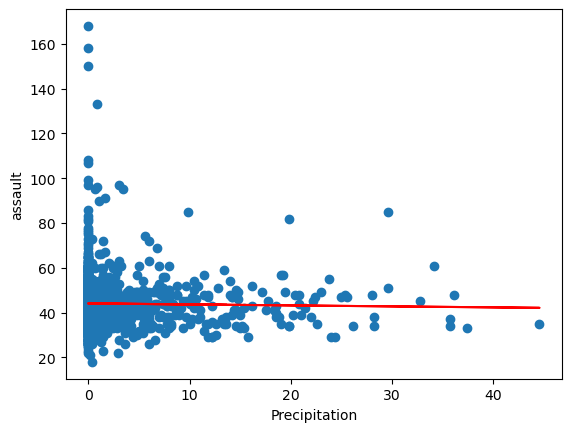

In [21]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.plot(X, y_pred, color='red')
plt.show()

In [22]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-0.04383535]
44.11096753816695


#### Auto Theft


In [23]:
# Define crime type variables
df = 'auto_theft_df'
crime_type = 'auto_theft'

In [24]:
# Drop the non-beneficial columns, from crime data
#joined_df.drop(columns=['occ_dow','auto_theftocc_year', 'occ_month', 'occ_day', 'occ_dow', 'occ_hour', 'premises_type', 'hood_140', 'neighbourhood_140', 'long_wgs84', 'lat_wgs84' ], inplace=True)
df = joined_df.copy()
df.drop(columns=['occ_dow','assault', 'bicycle_theft', 'break_and_enter', 'homicide', 'robbery', 'shooting', 'theft_from_motor_vehicle', 'theft_over'], inplace=True)

# # Drop the non-beneficial columns, from weather 
df.drop(columns=['date','max_temperature', 'min_temperature', 'max_relative_humidity', 'avg_relative_humidity', 'avg_pressure_sea', 'max_wind_speed', 'rain', 'snow', 'snow_on_ground', 'daylight', 'avg_cloud_cover_8'], inplace=True)

df

,precipitation,auto_theft
0,13.6,14
1,1.2,8
2,0.0,10
3,1.8,13
4,5.4,7
...,...,...
1456,0.8,6
1457,6.8,5
1458,10.8,10
1459,0.6,9


In [25]:
# Determine the number of unique values in each column.
unique =df.nunique()
unique

precipitation    112
auto_theft        26
dtype: int64

In [26]:
# Corrolation Matrix
corr_matrix = df.corr()

print(corr_matrix)

               precipitation  auto_theft
precipitation       1.000000    0.011177
auto_theft          0.011177    1.000000


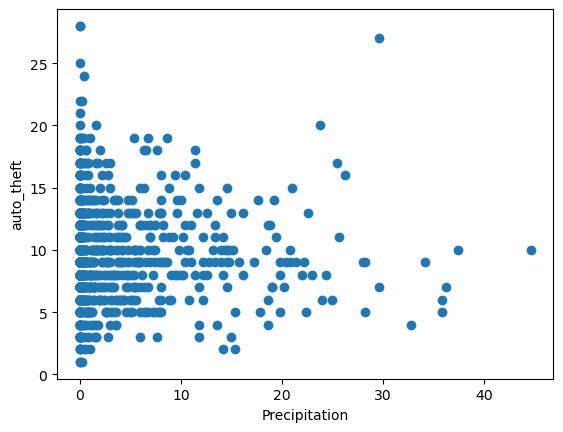

In [27]:
plt.scatter(df.precipitation, df[crime_type])
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [28]:
# The data in the df column must be reshaped into an array with shape (num_samples, num_features)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
X = df.precipitation.values.reshape(-1, 1)

X

array([[13.6],
       [ 1.2],
       [ 0. ],
       ...,
       [10.8],
       [ 0.6],
       [ 0. ]])

In [29]:
# The shape of X is 30 samples, with a single feature (column)
X.shape

(1461, 1)

In [30]:
y=df[crime_type]
y

0       14
1        8
2       10
3       13
4        7
        ..
1456     6
1457     5
1458    10
1459     9
1460     7
Name: auto_theft, Length: 1461, dtype: int64

In [31]:
# Create a model with scikit-learn
model = LinearRegression()

In [32]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [33]:
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)

(1461,)


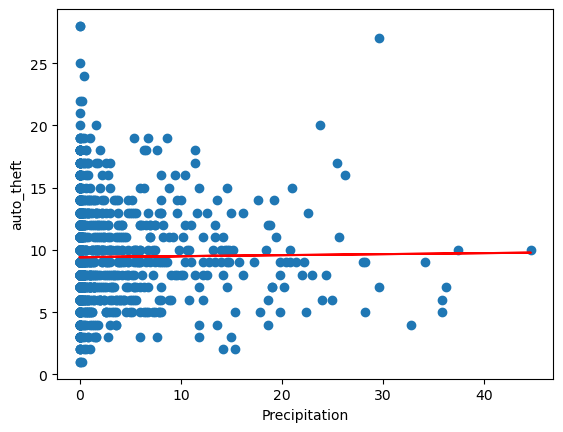

In [34]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [35]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[0.0081525]
9.415634281471243


## Bicycle Theft

In [36]:
# Define crime type variables
df = 'bicycle_theft'
crime_type = 'bicycle_theft'

In [37]:
# Drop the non-beneficial columns, from crime data
#joined_df.drop(columns=['occ_dow','auto_theftocc_year', 'occ_month', 'occ_day', 'occ_dow', 'occ_hour', 'premises_type', 'hood_140', 'neighbourhood_140', 'long_wgs84', 'lat_wgs84' ], inplace=True)
df = joined_df.copy()
df.drop(columns=['occ_dow', 'assault', 'auto_theft', 'break_and_enter', 'homicide', 'robbery', 'shooting', 'theft_from_motor_vehicle', 'theft_over'], inplace=True)

# # Drop the non-beneficial columns, from weather 
df.drop(columns=['date','max_temperature', 'min_temperature', 'max_relative_humidity', 'avg_relative_humidity', 'avg_pressure_sea', 'max_wind_speed', 'rain', 'snow', 'snow_on_ground', 'daylight', 'avg_cloud_cover_8'], inplace=True)

df


,precipitation,bicycle_theft
0,13.6,2
1,1.2,3
2,0.0,3
3,1.8,2
4,5.4,2
...,...,...
1456,0.8,1
1457,6.8,1
1458,10.8,0
1459,0.6,4


In [38]:
# Determine the number of unique values in each column.
unique =df.nunique()
unique

precipitation    112
bicycle_theft     32
dtype: int64

In [39]:
# Corrolation Matrix
corr_matrix = df.corr()

print(corr_matrix)

               precipitation  bicycle_theft
precipitation       1.000000      -0.096396
bicycle_theft      -0.096396       1.000000


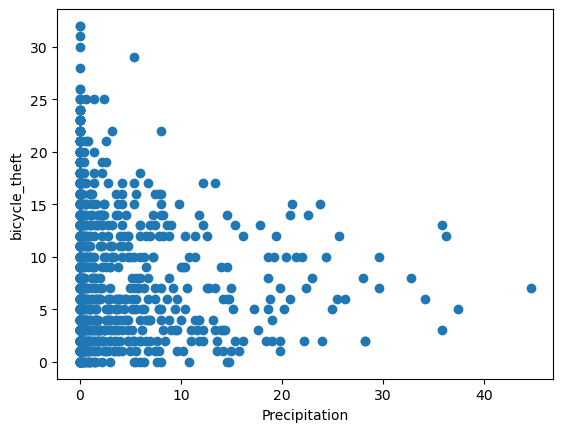

In [40]:
plt.scatter(df.precipitation, df[crime_type])
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [41]:
# The data in the df column must be reshaped into an array with shape (num_samples, num_features)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
X = df.precipitation.values.reshape(-1, 1)

In [42]:
# The shape of X is 30 samples, with a single feature (column)
X.shape

(1461, 1)

In [43]:
y=df[crime_type]
y

0       2
1       3
2       3
3       2
4       2
       ..
1456    1
1457    1
1458    0
1459    4
1460    5
Name: bicycle_theft, Length: 1461, dtype: int64

In [44]:
# Create a model with scikit-learn
model = LinearRegression()

In [45]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [46]:
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)

(1461,)


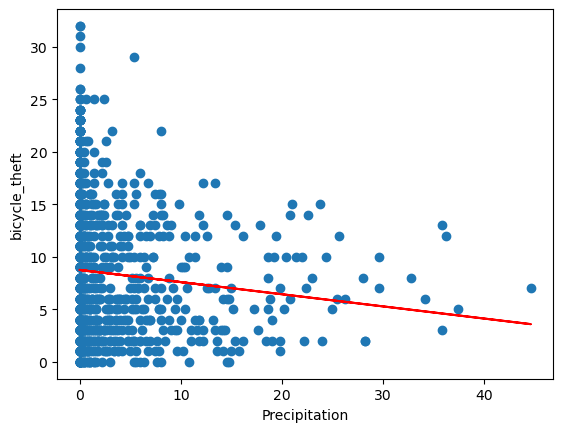

In [47]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [48]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-0.11574405]
8.760782421023382


#### Break and Enter

In [49]:
# Define crime type variables
df = 'bread_enter'
crime_type = 'break_and_enter'

In [50]:
# Drop the non-beneficial columns, from crime data
#joined_df.drop(columns=['occ_dow','auto_theftocc_year', 'occ_month', 'occ_day', 'occ_dow', 'occ_hour', 'premises_type', 'hood_140', 'neighbourhood_140', 'long_wgs84', 'lat_wgs84' ], inplace=True)
df = joined_df.copy()
df.drop(columns=['occ_dow','assault', 'auto_theft', 'bicycle_theft', 'homicide', 'robbery', 'shooting', 'theft_from_motor_vehicle', 'theft_over'], inplace=True)

# # Drop the non-beneficial columns, from weather 
df.drop(columns=['date','max_temperature', 'min_temperature', 'max_relative_humidity', 'avg_relative_humidity', 'avg_pressure_sea', 'max_wind_speed', 'rain', 'snow', 'snow_on_ground', 'daylight', 'avg_cloud_cover_8'], inplace=True)

df

,precipitation,break_and_enter
0,13.6,20
1,1.2,22
2,0.0,26
3,1.8,21
4,5.4,21
...,...,...
1456,0.8,24
1457,6.8,11
1458,10.8,4
1459,0.6,18


In [51]:
# Determine the number of unique values in each column.
unique = df.nunique()
unique

precipitation      112
break_and_enter     37
dtype: int64

In [52]:
# Corrolation Matrix
corr_matrix = df.corr()

print(corr_matrix)

                 precipitation  break_and_enter
precipitation         1.000000        -0.025432
break_and_enter      -0.025432         1.000000


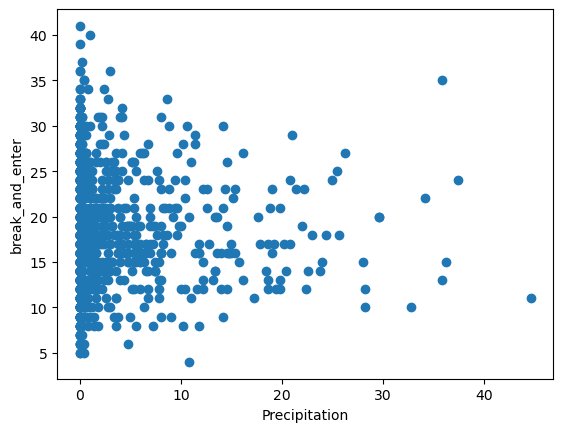

In [53]:
plt.scatter(df.precipitation, df[crime_type])
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [54]:
# The data in the df column must be reshaped into an array with shape (num_samples, num_features)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
X = df.precipitation.values.reshape(-1, 1)

In [55]:
# The shape of X is 30 samples, with a single feature (column)
X.shape

(1461, 1)

In [56]:
y=df[crime_type]
y

0       20
1       22
2       26
3       21
4       21
        ..
1456    24
1457    11
1458     4
1459    18
1460    21
Name: break_and_enter, Length: 1461, dtype: int64

In [57]:
# Create a model with scikit-learn
model = LinearRegression()

In [58]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [59]:
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)

(1461,)


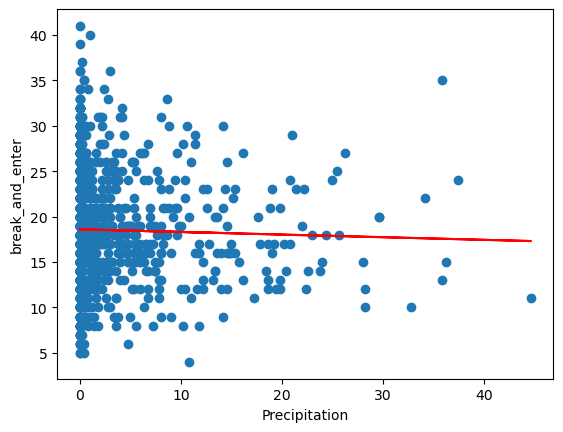

In [60]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [61]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-0.02887668]
18.599380967302405


## Homicides

In [62]:
# Define crime type variables
df = 'homicides'
crime_type = 'homicide'

In [63]:
# Drop the non-beneficial columns, from crime data
#joined_df.drop(columns=['occ_dow','auto_theftocc_year', 'occ_month', 'occ_day', 'occ_dow', 'occ_hour', 'premises_type', 'hood_140', 'neighbourhood_140', 'long_wgs84', 'lat_wgs84' ], inplace=True)
df = joined_df.copy()
df.drop(columns=['occ_dow','assault', 'auto_theft', 'bicycle_theft', 'break_and_enter', 'robbery', 'shooting', 'theft_from_motor_vehicle', 'theft_over'], inplace=True)

# # Drop the non-beneficial columns, from weather 
df.drop(columns=['date','max_temperature', 'min_temperature', 'max_relative_humidity', 'avg_relative_humidity', 'avg_pressure_sea', 'max_wind_speed', 'rain', 'snow', 'snow_on_ground', 'daylight', 'avg_cloud_cover_8'], inplace=True)

df

,precipitation,homicide
0,13.6,0
1,1.2,0
2,0.0,0
3,1.8,0
4,5.4,0
...,...,...
1456,0.8,0
1457,6.8,0
1458,10.8,0
1459,0.6,0


In [64]:
# Determine the number of unique values in each column.
unique = df.nunique()
unique

precipitation    112
homicide           3
dtype: int64

In [65]:
# Corrolation Matrix
corr_matrix = df.corr()

print(corr_matrix)

               precipitation  homicide
precipitation       1.000000  0.003218
homicide            0.003218  1.000000


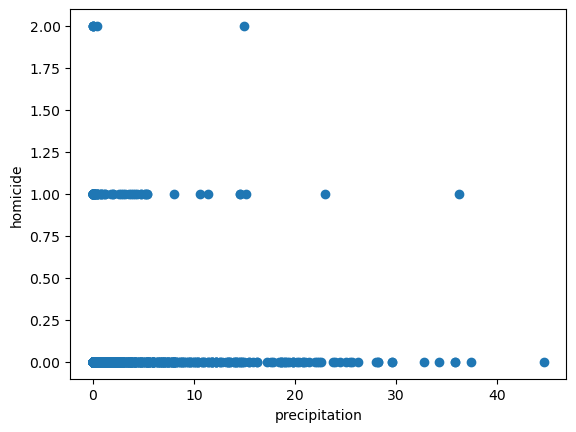

In [66]:
plt.scatter(df.precipitation, df[crime_type])
plt.xlabel('precipitation')
plt.ylabel(crime_type)
plt.show()

In [67]:
# The data in the df column must be reshaped into an array with shape (num_samples, num_features)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
X = df.precipitation.values.reshape(-1, 1)

In [68]:
# The shape of X is 30 samples, with a single feature (column)
X.shape

(1461, 1)

In [69]:
y=df[crime_type]
y

0       0
1       0
2       0
3       0
4       0
       ..
1456    0
1457    0
1458    0
1459    0
1460    0
Name: homicide, Length: 1461, dtype: int64

In [70]:
# Create a model with scikit-learn
model = LinearRegression()

In [71]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [72]:
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)

(1461,)


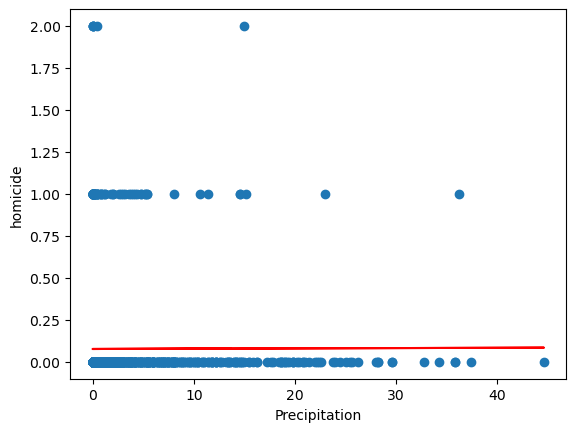

In [73]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [74]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[0.00017938]
0.07697141302275692


#### Robbery

In [75]:
# Define crime type variables
df = 'robbery'
crime_type = 'robbery'

In [76]:
# Drop the non-beneficial columns, from crime data
#joined_df.drop(columns=['occ_dow','auto_theftocc_year', 'occ_month', 'occ_day', 'occ_dow', 'occ_hour', 'premises_type', 'hood_140', 'neighbourhood_140', 'long_wgs84', 'lat_wgs84' ], inplace=True)
df = joined_df.copy()
df.drop(columns=['occ_dow','assault', 'auto_theft', 'bicycle_theft', 'break_and_enter', 'homicide', 'shooting', 'theft_from_motor_vehicle', 'theft_over'], inplace=True)

# # Drop the non-beneficial columns, from weather 
df.drop(columns=['date','max_temperature', 'min_temperature', 'max_relative_humidity', 'avg_relative_humidity', 'avg_pressure_sea', 'max_wind_speed', 'rain', 'snow', 'snow_on_ground', 'daylight', 'avg_cloud_cover_8'], inplace=True)

df

,precipitation,robbery
0,13.6,11
1,1.2,7
2,0.0,7
3,1.8,12
4,5.4,7
...,...,...
1456,0.8,5
1457,6.8,5
1458,10.8,8
1459,0.6,6


In [77]:
# Determine the number of unique values in each column.
unique = df.nunique()
unique

precipitation    112
robbery           21
dtype: int64

In [78]:
# Corrolation Matrix
corr_matrix = df.corr()

print(corr_matrix)

               precipitation   robbery
precipitation       1.000000 -0.074161
robbery            -0.074161  1.000000


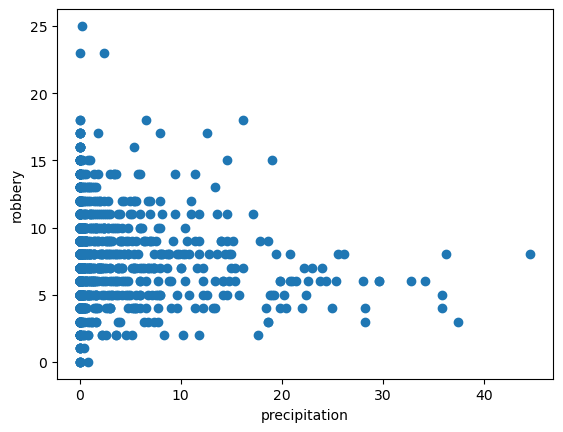

In [79]:
plt.scatter(df.precipitation, df[crime_type])
plt.xlabel('precipitation')
plt.ylabel(crime_type)
plt.show()

In [80]:
# The data in the df column must be reshaped into an array with shape (num_samples, num_features)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
X = df.precipitation.values.reshape(-1, 1)

In [81]:
# The shape of X is 30 samples, with a single feature (column)
X.shape

(1461, 1)

In [82]:
y=df[crime_type]
y

0       11
1        7
2        7
3       12
4        7
        ..
1456     5
1457     5
1458     8
1459     6
1460     8
Name: robbery, Length: 1461, dtype: int64

In [83]:
# Create a model with scikit-learn
model = LinearRegression()

In [84]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [85]:
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)

(1461,)


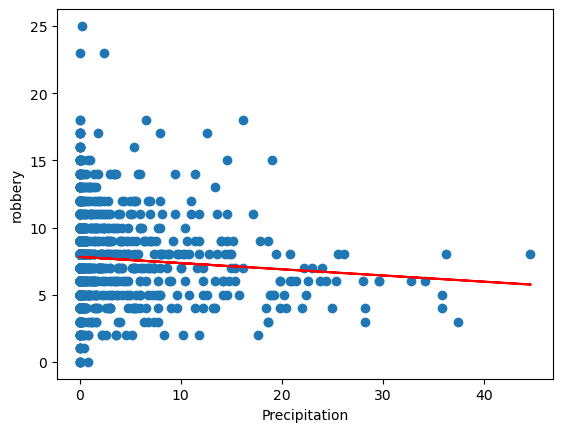

In [86]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [87]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-0.0461033]
7.815202670145071


#### Shooting

In [88]:
# Define crime type variables
df = 'shooting'
crime_type = 'shooting'

In [89]:
# Drop the non-beneficial columns, from crime data
#joined_df.drop(columns=['occ_dow','auto_theftocc_year', 'occ_month', 'occ_day', 'occ_dow', 'occ_hour', 'premises_type', 'hood_140', 'neighbourhood_140', 'long_wgs84', 'lat_wgs84' ], inplace=True)
df = joined_df.copy()
df.drop(columns=['occ_dow','assault', 'auto_theft', 'bicycle_theft', 'break_and_enter', 'robbery', 'homicide', 'theft_from_motor_vehicle', 'theft_over'], inplace=True)

# # Drop the non-beneficial columns, from weather 
df.drop(columns=['date','max_temperature', 'min_temperature', 'max_relative_humidity', 'avg_relative_humidity', 'avg_pressure_sea', 'max_wind_speed', 'rain', 'snow', 'snow_on_ground', 'daylight', 'avg_cloud_cover_8'], inplace=True)

df

,precipitation,shooting
0,13.6,0
1,1.2,0
2,0.0,0
3,1.8,0
4,5.4,0
...,...,...
1456,0.8,1
1457,6.8,0
1458,10.8,0
1459,0.6,0


In [90]:
# Determine the number of unique values in each column.
unique = df.nunique()
unique

precipitation    112
shooting           4
dtype: int64

In [91]:
# Corrolation Matrix
corr_matrix = df.corr()

print(corr_matrix)

               precipitation  shooting
precipitation       1.000000 -0.039954
shooting           -0.039954  1.000000


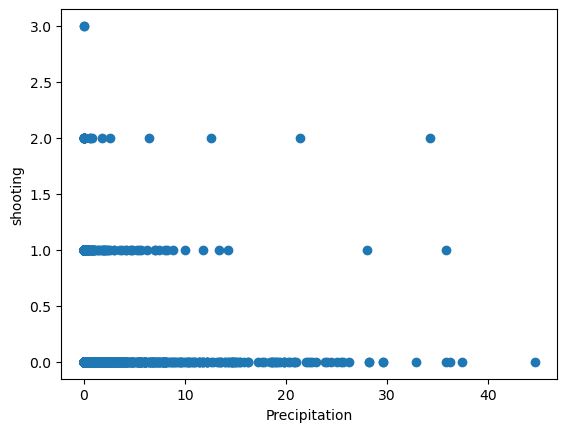

In [92]:
plt.scatter(df.precipitation, df[crime_type])
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [93]:
# The data in the df column must be reshaped into an array with shape (num_samples, num_features)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
X = df.precipitation.values.reshape(-1, 1)

In [94]:
# The shape of X is 30 samples, with a single feature (column)
X.shape

(1461, 1)

In [95]:
y=df[crime_type]
y

0       0
1       0
2       0
3       0
4       0
       ..
1456    1
1457    0
1458    0
1459    0
1460    0
Name: shooting, Length: 1461, dtype: int64

In [96]:
# Create a model with scikit-learn
model = LinearRegression()

In [97]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [98]:
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)

(1461,)


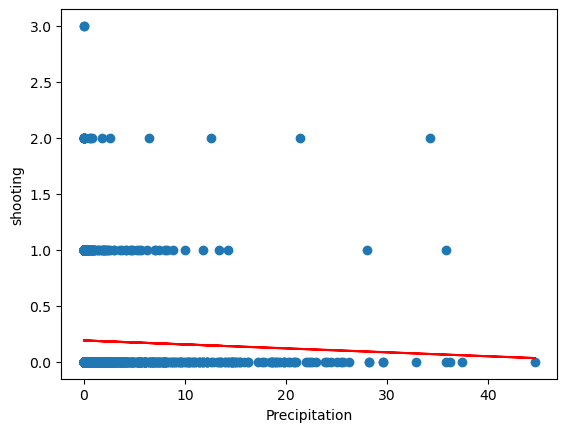

In [99]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [100]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-0.00352599]
0.19144973895768375


#### Theft from Motor Vehicle

In [101]:
# Define crime type variables
df = 'theft_from_vehicle'
crime_type = 'theft_from_motor_vehicle'

In [102]:
# Drop the non-beneficial columns, from crime data
#joined_df.drop(columns=['occ_dow','auto_theftocc_year', 'occ_month', 'occ_day', 'occ_dow', 'occ_hour', 'premises_type', 'hood_140', 'neighbourhood_140', 'long_wgs84', 'lat_wgs84' ], inplace=True)
df = joined_df.copy()
df.drop(columns=['occ_dow','assault', 'auto_theft', 'bicycle_theft', 'break_and_enter', 'robbery', 'homicide', 'shooting', 'theft_over'], inplace=True)

# # Drop the non-beneficial columns, from weather 
df.drop(columns=['date','max_temperature', 'min_temperature', 'max_relative_humidity', 'avg_relative_humidity', 'avg_pressure_sea', 'max_wind_speed', 'rain', 'snow', 'snow_on_ground', 'daylight', 'avg_cloud_cover_8'], inplace=True)

df

,precipitation,theft_from_motor_vehicle
0,13.6,23
1,1.2,22
2,0.0,21
3,1.8,31
4,5.4,30
...,...,...
1456,0.8,31
1457,6.8,33
1458,10.8,21
1459,0.6,34


In [103]:
# Determine the number of unique values in each column.
unique = df.nunique()
unique

precipitation               112
theft_from_motor_vehicle     42
dtype: int64

In [104]:
# Corrolation Matrix
corr_matrix = df.corr()

print(corr_matrix)

                          precipitation  theft_from_motor_vehicle
precipitation                   1.00000                  -0.03358
theft_from_motor_vehicle       -0.03358                   1.00000


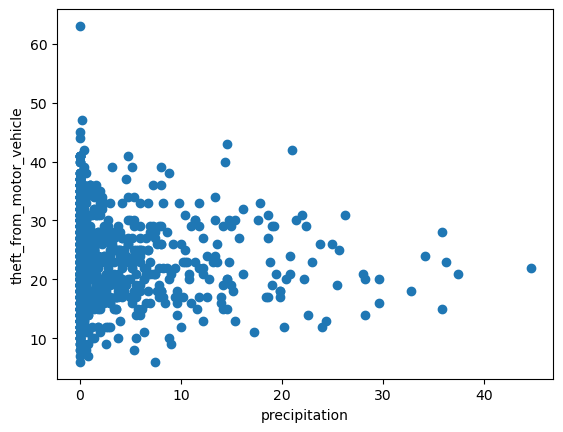

In [105]:
plt.scatter(df.precipitation, df[crime_type])
plt.xlabel('precipitation')
plt.ylabel(crime_type)
plt.show()

In [106]:
# The data in the df column must be reshaped into an array with shape (num_samples, num_features)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
X = df.precipitation.values.reshape(-1, 1)

In [107]:
# The shape of X is 30 samples, with a single feature (column)
X.shape

(1461, 1)

In [108]:
y=df[crime_type]
y

0       23
1       22
2       21
3       31
4       30
        ..
1456    31
1457    33
1458    21
1459    34
1460    34
Name: theft_from_motor_vehicle, Length: 1461, dtype: int64

In [109]:
# Create a model with scikit-learn
model = LinearRegression()

In [110]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [111]:
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)

(1461,)


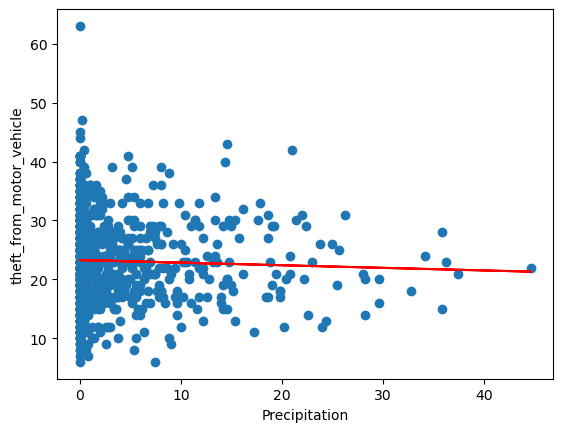

In [112]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [113]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-0.04407804]
23.28190322651545


#### Theft Over

In [114]:
# Define crime type variables
df = 'theft_over'
crime_type = 'theft_over'

In [115]:
# Drop the non-beneficial columns, from crime data
#joined_df.drop(columns=['occ_dow','auto_theftocc_year', 'occ_month', 'occ_day', 'occ_dow', 'occ_hour', 'premises_type', 'hood_140', 'neighbourhood_140', 'long_wgs84', 'lat_wgs84' ], inplace=True)
df = joined_df.copy()
df.drop(columns=['occ_dow','assault', 'auto_theft', 'bicycle_theft', 'break_and_enter', 'robbery', 'shooting', 'theft_from_motor_vehicle', 'homicide'], inplace=True)

# # Drop the non-beneficial columns, from weather 
df.drop(columns=['date','max_temperature', 'min_temperature', 'max_relative_humidity', 'avg_relative_humidity', 'avg_pressure_sea', 'max_wind_speed', 'rain', 'snow', 'snow_on_ground', 'daylight', 'avg_cloud_cover_8'], inplace=True)

df

,precipitation,theft_over
0,13.6,4
1,1.2,3
2,0.0,4
3,1.8,1
4,5.4,1
...,...,...
1456,0.8,2
1457,6.8,1
1458,10.8,3
1459,0.6,2


In [116]:
# Determine the number of unique values in each column.
unique = df.nunique()
unique

precipitation    112
theft_over        13
dtype: int64

In [117]:
# Corrolation Matrix
corr_matrix = df.corr()

print(corr_matrix)

               precipitation  theft_over
precipitation       1.000000   -0.024468
theft_over         -0.024468    1.000000


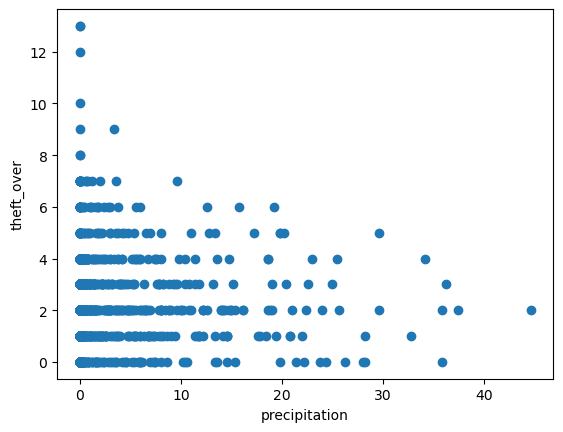

In [118]:
plt.scatter(df.precipitation, df[crime_type])
plt.xlabel('precipitation')
plt.ylabel(crime_type)
plt.show()

In [119]:
# The data in the df column must be reshaped into an array with shape (num_samples, num_features)
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
X = df.precipitation.values.reshape(-1, 1)

In [120]:
# The shape of X is 30 samples, with a single feature (column)
X.shape

(1461, 1)

In [121]:
y=df[crime_type]
y

0       4
1       3
2       4
3       1
4       1
       ..
1456    2
1457    1
1458    3
1459    2
1460    5
Name: theft_over, Length: 1461, dtype: int64

In [122]:
# Create a model with scikit-learn
model = LinearRegression()

In [123]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [124]:
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)

(1461,)


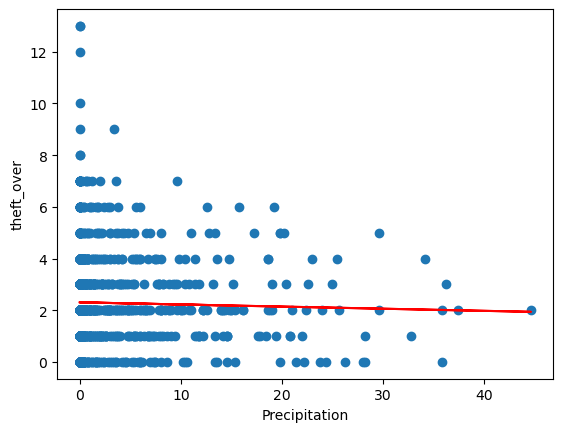

In [125]:
# Plot the results. The best fit line is red.
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Precipitation')
plt.ylabel(crime_type)
plt.show()

In [126]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-0.0082143]
2.305233406934379
